Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
X_scaled shape: (415872, 23)
control_mean_expanded shape: (415872, 23)
control_std_expanded shape: (415872, 23)
Epoch 1/10, Loss: 0.7027588987329839
Epoch 2/10, Loss: 0.5965944138262098
Epoch 3/10, Loss: 0.5786983609508891
Epoch 4/10, Loss: 0.5672967322557443
Epoch 5/10, Loss: 0.5594567748811419
Epoch 6/10, Loss: 0.5537172989036797
Epoch 7/10, Loss: 0.5453738123178482
Epoch 8/10, Loss: 0.5428589064254068
Epoch 9/10, Loss: 0.5333600879024882
Epoch 10/10, Loss: 0.5308199139202342
Test Accuracy: 73.34%


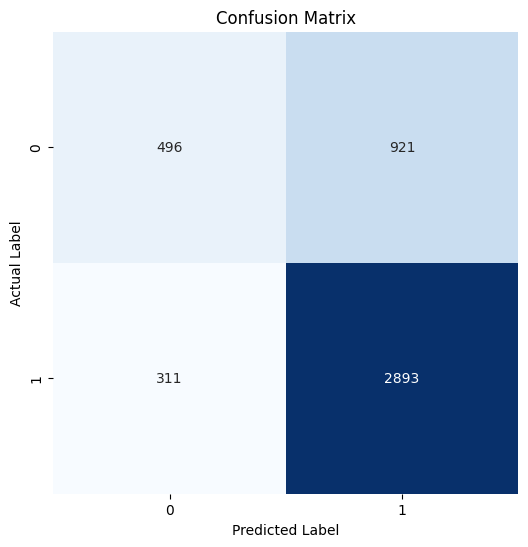

              precision    recall  f1-score   support

         0.0       0.61      0.35      0.45      1417
         1.0       0.76      0.90      0.82      3204

    accuracy                           0.73      4621
   macro avg       0.69      0.63      0.64      4621
weighted avg       0.71      0.73      0.71      4621



In [ ]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
import xml.etree.ElementTree as ET
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Mount Google Drive (if on Colab)
from google.colab import drive
drive.mount('/content/drive')

# Paths
original_data_path = '/content/drive/My Drive/cybersummer/final_df.csv'
single_control_file = '/content/drive/My Drive/control_data/detector_data_c_9_13398.xml'

# Function to read data from a single XML file and extract <interval> attributes
def read_xml_to_dataframe(filepath):
    tree = ET.parse(filepath)
    root = tree.getroot()
    data = []

    # Loop through each interval element and extract attributes
    for interval in root.findall('interval'):
        row = interval.attrib  # Extract all attributes as a dictionary
        data.append(row)

    # Convert list of dictionaries to DataFrame
    df = pd.DataFrame(data)

    # Convert all columns to numeric, forcing errors to NaN (in case of non-numeric values)
    df = df.apply(pd.to_numeric, errors='coerce')

    return df

# Load the single control file
control_data = read_xml_to_dataframe(single_control_file)

# Drop the unnecessary columns to match the structure of the original dataset
control_data = control_data.drop(columns=['Target', 'begin', 'end', 'id'], errors='ignore')

# Calculate mean and standard deviation for each 10-second interval (18 rows at a time)
interval_means = []
interval_stds = []
for i in range(0, control_data.shape[0], 18):
    interval_chunk = control_data.iloc[i:i+18]
    mean_chunk = interval_chunk.mean().values.reshape(1, -1)  # Shape (1, 23)
    std_chunk = interval_chunk.std().values.reshape(1, -1)  # Shape (1, 23)
    interval_means.append(np.tile(mean_chunk, (18, 1)))  # Expand to (18, 23)
    interval_stds.append(np.tile(std_chunk, (18, 1)))  # Expand to (18, 23)

# Concatenate means and stds to cover the control dataset
control_mean_expanded = np.vstack(interval_means)
control_std_expanded = np.vstack(interval_stds)

# Load the original dataset
final_df = pd.read_csv(original_data_path)

# Drop specific columns
X = final_df.drop(columns=['Target', 'begin', 'end', 'id'])
y = final_df['Target']

# Scale the original dataset
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape the original data into 18-row blocks (samples)
num_rows = X_scaled.shape[0]
num_samples = num_rows // 18  # Number of 18-row samples
X_scaled = X_scaled[:num_samples * 18].reshape(num_samples * 18, 23)

# Expand control_mean_expanded and control_std_expanded to match the shape of X_scaled
num_repeats = X_scaled.shape[0] // control_mean_expanded.shape[0]
control_mean_expanded = np.tile(control_mean_expanded, (num_repeats, 1))
control_std_expanded = np.tile(control_std_expanded, (num_repeats, 1))

# Confirm shapes before stacking
print("X_scaled shape:", X_scaled.shape)
print("control_mean_expanded shape:", control_mean_expanded.shape)
print("control_std_expanded shape:", control_std_expanded.shape)

# Stack the three channels together
X_3channel = np.stack([X_scaled, control_mean_expanded, control_std_expanded], axis=1)

# Reshape for CNN input: (num_samples, 3 channels, 18 rows, 23 features)
X_cnn_input_3channel = X_3channel.reshape(num_samples, 3, 18, 23)

# Transform 'Target' into binary labels: 1 for 'normal' (5), 0 for 'abnormal' (others)
y_binary = final_df['Target'].map(lambda x: 1 if x == 5 else 0)
y_labels = y_binary.iloc[::18].values[:num_samples]

# Split data into train and test sets with the 3-channel input
X_train, X_test, y_train, y_test = train_test_split(X_cnn_input_3channel, y_labels, test_size=0.2, random_state=50)

# Convert to PyTorch tensors for CNN
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Define CNN Model with 3 input channels
class CNN2D(nn.Module):
    def __init__(self):
        super(CNN2D, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3))
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3))
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))
        self._calculate_conv_output_size()
        self.fc1 = nn.Linear(self.conv_output_size, 64)
        self.fc2 = nn.Linear(64, 1)

    def _calculate_conv_output_size(self):
        dummy_input = torch.zeros(1, 3, 18, 23)
        x = self.pool(torch.relu(self.conv1(dummy_input)))
        x = self.pool(torch.relu(self.conv2(x)))
        self.conv_output_size = x.numel()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Instantiate the model, loss function, and optimizer
model = CNN2D()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
n_epochs = 10
batch_size = 32
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {running_loss/len(train_loader)}")

# Evaluation
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor)
    y_pred_test = (y_pred_test > 0.5).float()

# Calculate accuracy
accuracy = (y_pred_test == y_test_tensor).sum().item() / y_test_tensor.size(0)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
y_pred_test_np = y_pred_test.numpy()
y_test_np = y_test_tensor.numpy()
cm = confusion_matrix(y_test_np, y_pred_test_np)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

# Classification Report
print(classification_report(y_test_np, y_pred_test_np))
